In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import arviz as az
from sklearn.preprocessing import StandardScaler

# Import of our custom uncertainty evaluation class (must be in the same folder)
from uncertainty_metrics import UncertaintyEvaluator

In [2]:
# === CONFIGURATION ===
SCRIPT_PATH = os.getcwd()
# Adjust paths according to your project structure
DATA_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', '..', 'data', 'preprocessed', 'analysis_data'))
MODELS_DIR_BASE = os.path.abspath(os.path.join(SCRIPT_PATH, '..',  '..', 'models'))
FEATURES_NAMES_DIR = os.path.abspath(os.path.join(DATA_DIR,'feature_names.pkl'))
ENCODER_PATH = os.path.join(MODELS_DIR_BASE, 'qda', 'label_encoder.pkl')

# Load test dataset
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
target_col = 'Fault_Condition'
feature_cols = joblib.load(FEATURES_NAMES_DIR)

X_test = test_data[feature_cols]
y_test_raw = test_data[target_col]

# === LOAD ENCODER ===
if os.path.exists(ENCODER_PATH):
    le = joblib.load(ENCODER_PATH)
    print(f"abelEncoder loaded. Clases: {le.classes_}")

    y_test = le.transform(y_test_raw)
else:
    raise FileNotFoundError("File label_encoder.pkl not found! Please ensure the encoder is saved during model training.")


print(f"Number of test samples: {len(X_test)}")

abelEncoder loaded. Clases: ['faulty' 'faulty_zip' 'healthy' 'healthy_zip']
Number of test samples: 56


In [3]:
# === RESULT CONTAINERS ===
comparison_table = []
uncertainty_details = {}  # Stores entropy vectors for histogram / density plots

In [4]:

# --- 1. RANDOM FOREST (Ensemble) ---
try:
    rf_path = os.path.join(MODELS_DIR_BASE, 'random_forest', 'random_forest.pkl')  # Verify path in your setup
    rf_model = joblib.load(rf_path)

    # Use dedicated method to extract tree-level variance (epistemic uncertainty)
    probs_rf, var_rf = UncertaintyEvaluator.extract_rf_uncertainty(rf_model, X_test)

    evaluator = UncertaintyEvaluator(y_test, "Random Forest")
    metrics, entropy_rf, _ = evaluator.compute_metrics(probs_rf, epistemic_var=var_rf)
    comparison_table.append(metrics)
    uncertainty_details["Random Forest"] = entropy_rf
    print("Random Forest analyzed.")
except FileNotFoundError:
    print("Random Forest model not found.")

Random Forest analyzed.


In [5]:
# --- 2. XGBOOST (Gradient Boosting) ---
try:
    xgb_path = os.path.join(MODELS_DIR_BASE, 'xgboost', 'XGBoost.pkl')  # Verify path
    xgb_model = joblib.load(xgb_path)

    # XGBoost provides class probabilities directly
    probs_xgb = xgb_model.predict_proba(X_test)

    evaluator = UncertaintyEvaluator(y_test, "XGBoost")
    metrics, entropy_xgb, _ = evaluator.compute_metrics(probs_xgb)
    comparison_table.append(metrics)
    uncertainty_details["XGBoost"] = entropy_xgb
    print("XGBoost analyzed.")
except FileNotFoundError:
    print("XGBoost model not found.")

XGBoost analyzed.


In [6]:
# --- 3. GAUSSIAN NAIVE BAYES ---
try:
    gnb_path = os.path.join(MODELS_DIR_BASE, 'naive_bayes', 'gaussian_naive_bayes.pkl')
    gnb_model = joblib.load(gnb_path)

    probs_gnb = gnb_model.predict_proba(X_test)

    evaluator = UncertaintyEvaluator(y_test, "Gaussian NB")
    metrics, entropy_gnb, _ = evaluator.compute_metrics(probs_gnb)
    comparison_table.append(metrics)
    uncertainty_details["Gaussian NB"] = entropy_gnb
    print("GNB analyzed.")
except FileNotFoundError:
    print("GNB model not found.")

GNB analyzed.


In [7]:
# --- 4. QDA ---
try:
    qda_path = os.path.join(MODELS_DIR_BASE, 'qda', 'qda_model.pkl')
    qda_model = joblib.load(qda_path)

    probs_qda = qda_model.predict_proba(X_test)

    evaluator = UncertaintyEvaluator(y_test, "QDA")
    metrics, entropy_qda, _ = evaluator.compute_metrics(probs_qda)
    comparison_table.append(metrics)
    uncertainty_details["QDA"] = entropy_qda
    print("QDA analyzed.")
except FileNotFoundError:
    print("QDA model not found.")


QDA analyzed.


In [8]:
# --- 5. BAYESIAN SOFTMAX (PyMC) ---
try:
    trace_path = os.path.join(MODELS_DIR_BASE, 'bayesian', 'bayesian_trace.nc')
    scaler_path = os.path.join(MODELS_DIR_BASE, 'bayesian', 'scaler.pkl')

    # Load class map (now guarantees strings matching le.classes_)
    bayes_map_path = os.path.join(MODELS_DIR_BASE, 'bayesian', 'class_map.pkl')
    bayes_map = joblib.load(bayes_map_path)

    trace = az.from_netcdf(trace_path)
    scaler = joblib.load(scaler_path)

    # Bayesian model requires test data to be scaled with the same scaler
    X_test_scaled = scaler.transform(X_test)

    # Extract uncertainty using the map from the model
    probs_bayes, var_bayes = UncertaintyEvaluator.extract_bayesian_uncertainty(
        trace, X_test_scaled, bayes_map
    )

    # === COLUMN SYNCHRONIZATION ===
    bayes_idx_map = {name: i for i, name in enumerate(bayes_map)}

    new_order = [bayes_idx_map[label_name] for label_name in le.classes_]
    probs_bayes_corrected = probs_bayes[:, new_order]

    evaluator = UncertaintyEvaluator(y_test, "Bayesian Softmax")
    metrics, entropy_bayes, _ = evaluator.compute_metrics(
        probs_bayes_corrected, epistemic_var=var_bayes
    )
    comparison_table.append(metrics)
    uncertainty_details["Bayesian Softmax"] = entropy_bayes
    print("Bayesian model analyzed.")

except Exception as e:
    print(f"Bayesian model error: {e}")

Bayesian model analyzed.



=== MODEL RANKING BY UNCERTAINTY QUALITY ===
Best model has LOWEST NLL and ECE, and HIGHEST Accuracy.


,Accuracy,NLL,Brier Score,ECE,Avg Entropy (Total Uncertainty),Avg Epistemic Var
Model,,,,,,
Random Forest,0.982143,0.136118,0.052122,0.105940,0.327659,0.034827
XGBoost,0.982143,0.249463,0.088475,0.175050,0.646908,nan
Gaussian NB,0.964286,0.245127,0.079964,0.042609,0.035565,nan
QDA,0.910714,0.235763,0.137325,0.053413,0.335714,nan
Bayesian Softmax,0.928571,0.220374,0.121819,0.092748,0.375369,0.020395


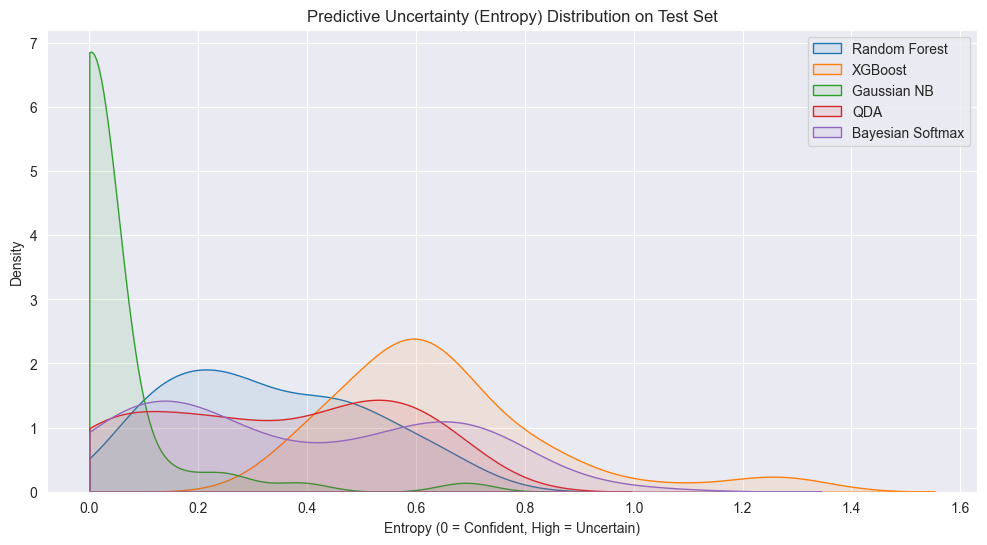


Generating calibration diagram for best-calibrated model: Gaussian NB


In [9]:
# === SUMMARY AND VISUALIZATION ===

df_results = pd.DataFrame(comparison_table).set_index("Model")

print("\n=== MODEL RANKING BY UNCERTAINTY QUALITY ===")
print("Best model has LOWEST NLL and ECE, and HIGHEST Accuracy.")
display(
    df_results.style
        .background_gradient(cmap='viridis', subset=['Accuracy', 'Avg Epistemic Var'])
        .background_gradient(cmap='viridis_r', subset=['NLL', 'Brier Score', 'ECE'])
)

# Visualization 1: Entropy distribution (model confidence behavior)
plt.figure(figsize=(12, 6))
for name, entropies in uncertainty_details.items():
    sns.kdeplot(entropies, label=name, clip=(0, None), fill=True, alpha=0.1)
plt.title("Predictive Uncertainty (Entropy) Distribution on Test Set")
plt.xlabel("Entropy (0 = Confident, High = Uncertain)")
plt.legend()
plt.show()

# Visualization 2: Reliability Diagram (Calibration) for the best-calibrated model
# Select model with the lowest ECE
best_model_name = df_results['ECE'].idxmin()
print(f"\nGenerating calibration diagram for best-calibrated model: {best_model_name}")

# (Simplified placeholder logic – in a full implementation, probabilities should be stored explicitly)
# Assumes probs_rf, probs_bayes, etc. are still available in memory